In [2]:
from mylib.statistic_test import *

code_id = '0346 - GLM for all sessions'
loc = os.path.join(figpath, code_id)
mkdir(loc)

from mylib.model.glms import GLM as GenearlizedLinearModel
from mylib.model import EqualRateDriftModel, TwoProbDriftModel
from mylib.model import TwoProbabilityIndependentModel
from mylib.model import JointProbabilityModel
from mylib.model import HMM
from mylib.model import ContinuousHiddenStateModel
from mylib.model import ProbabilityRNN, IntegrativeRNN

from mylib.field.tracker_v2 import Tracker2d

def fit_models2(field_reg, GLM: np.ndarray, qualified_idx: np.ndarray, file_name: str):
    Models = {}

    res = {
        "Step": [],
        "Loss": [],
        "Model Type": []
    }
    
    idx = np.where(field_reg == 0)
    # Standardization
    for j in range(GLM.shape[2]):
        mean, std = np.nanmean(GLM[:, :, j]), np.nanstd(GLM[:, :, j])
        GLM[:, :, j] = (GLM[:, :, j] - mean) / std

    GLM = GLM[:, :, [0, 1, 2, 4, 5, 6, 7, 8, 9]]
    print(f"Orignial shape: {field_reg.shape}, qualified shape: {qualified_idx.shape[0]}")
    #field_reg = field_reg[:, qualified_idx]
    tracker = Tracker2d(field_reg=field_reg)
    sequences = tracker.convert_to_sequence()
    lengths = np.array([len(seq) for seq in sequences])
    
    max_length = np.max(lengths)
    if max_length > 10:
        sequences, glm_params = tracker.convert_for_glm(field_reg, GLM, least_length=10, is_seq_format=True)
    else:
        sequences, glm_params = tracker.convert_for_glm(field_reg, GLM, least_length=5, is_seq_format=True)
    
    train_size = int(len(sequences) * 0.8)
    train_indices = np.random.choice(len(sequences), train_size, replace=False)
    test_indices = np.setdiff1d(np.arange(len(sequences)), train_indices)
    res['train_indices'] = train_indices
    res['train_size'] = 0.8
    res['sequences'] = sequences
    
    train_seq = [sequences[i] for i in train_indices]
    test_seq = [sequences[i] for i in test_indices]
    M1 = EqualRateDriftModel()
    M1.fit(train_seq)
    res['Loss'].append(M1.calc_loss_along_seq(test_seq))
    res['Model Type'].append(np.repeat("Model I - 1", max_length-1))
    res['Step'].append(np.arange(1, max_length))
    res['Step'].append(np.arange(1, max_length))
    
    M12 = TwoProbDriftModel()
    M12.fit(train_seq)
    res['Loss'].append(M12.calc_loss_along_seq(test_seq))
    res['Model Type'].append(np.repeat("Model I - 2", max_length-1))
    res['Step'].append(np.arange(1, max_length))

    M2 = TwoProbabilityIndependentModel()
    M2.fit(train_seq)
    res['Loss'].append(M2.calc_loss_along_seq(test_seq))
    res['Model Type'].append(np.repeat("Model II", max_length-1))
    res['Step'].append(np.arange(1, max_length))

    M3 = JointProbabilityModel()
    M3.fit(train_seq)
    res['Loss'].append(M3.calc_loss_along_seq(test_seq))
    res['Model Type'].append(np.repeat("Model III", max_length-1))
    res['Step'].append(np.arange(1, max_length))

    M41 = HMM.process_fit(N=5, sequences=train_seq, n_iterations=100)
    res['Loss'].append(M41.calc_loss_along_seq(test_seq))
    res['Model Type'].append(np.repeat("Model IV - 5", max_length-1))
    res['Step'].append(np.arange(1, max_length))
    
    M42 = HMM.process_fit(N=10, sequences=train_seq, n_iterations=100)
    res['Loss'].append(M42.calc_loss_along_seq(test_seq))
    res['Model Type'].append(np.repeat("Model IV - 10", max_length-1))
    res['Step'].append(np.arange(1, max_length))

    M43 = HMM.process_fit(N=20, sequences=train_seq, n_iterations=100)
    res['Loss'].append(M43.calc_loss_along_seq(test_seq))
    res['Model Type'].append(np.repeat("Model IV - 20", max_length-1))
    res['Step'].append(np.arange(1, max_length))

    M44 = HMM.process_fit(N=40, sequences=train_seq, n_iterations=100)
    res['Loss'].append(M44.calc_loss_along_seq(test_seq))
    res['Model Type'].append(np.repeat("Model IV - 40", max_length-1))
    res['Step'].append(np.arange(1, max_length))

    M51 = ContinuousHiddenStateModel('reci')
    M51.fit(train_seq)
    res['Loss'].append(M51.calc_loss_along_seq(test_seq))
    res['Model Type'].append(np.repeat("Model V - reci", max_length-1))
    res['Step'].append(np.arange(1, max_length))

    M52 = ContinuousHiddenStateModel('logistic')
    M52.fit(train_seq)
    res['Loss'].append(M52.calc_loss_along_seq(test_seq))
    res['Model Type'].append(np.repeat("Model V - logistic", max_length-1))
    res['Step'].append(np.arange(1, max_length))

    M53 = ContinuousHiddenStateModel('poly2')
    M53.fit(train_seq)
    res['Loss'].append(M53.calc_loss_along_seq(test_seq))
    res['Model Type'].append(np.repeat("Model V - poly2", max_length-1))
    res['Step'].append(np.arange(1, max_length))
    
    M54 = ContinuousHiddenStateModel('poly3')
    M54.fit(train_seq)
    res['Loss'].append(M54.calc_loss_along_seq(test_seq))
    res['Model Type'].append(np.repeat("Model V - poly3", max_length-1))
    res['Step'].append(np.arange(1, max_length))

    M61 = ProbabilityRNN.process_fit(
        sequences,
        train_index=train_indices,
        hidden_size=8,
        lr=0.001,
        epochs=1000, 
        batch_size=2048
    )
    res['Loss'].append(M61.calc_loss_along_seq(test_seq))
    res['Model Type'].append(np.repeat("Model VI - 8", max_length-1)) 
    res['Step'].append(np.arange(1, max_length))

    M62 = ProbabilityRNN.process_fit(
        sequences,
        train_index=train_indices,
        hidden_size=16,
        lr=0.001,
        epochs=1000, 
        batch_size=2048
    )
    res['Loss'].append(M62.calc_loss_along_seq(test_seq))
    res['Model Type'].append(np.repeat("Model VI - 16", max_length-1)) 
    res['Step'].append(np.arange(1, max_length))

    M63 = ProbabilityRNN.process_fit(
        sequences,
        train_index=train_indices,
        hidden_size=32,
        lr=0.001,
        epochs=1000, 
        batch_size=2048
    )
    res['Loss'].append(M63.calc_loss_along_seq(test_seq))
    res['Model Type'].append(np.repeat("Model VI - 32", max_length-1))
    res['Step'].append(np.arange(1, max_length))


    """
    # Process NAN values
    for i in range(len(sequences)):
        nanidx = np.where(np.isnan(glm_params[i][:, :6]))[0]
        if len(nanidx) > 0:
            glm_params[i][nanidx] = 0
        
        # First Lap Appear
        nanidx = np.where(np.isnan(glm_params[i][:, 6]))[0]
        # Get session id
        if len(nanidx) > 0:
            session_id = glm_params[i][nanidx, 1].astype(int)-1
            glm_params[i][nanidx, 6] = np.nanmax(GLM[session_id, :, 6], axis=1)+1
        
        # BTSP-like signature
        nanidx = np.where(np.isnan(glm_params[i][:, [7,8]]))[0]
        if len(nanidx) > 0:   
            glm_params[i][nanidx, :][:, [7,8]] = 1
        
        # Fluctuation
        nanidx = np.where(np.isnan(glm_params[i][:, 9]))[0]
        if len(nanidx) > 0:    
            session_id = glm_params[i][nanidx, 1].astype(int)-1
            glm_params[i][nanidx, 9] = np.nanmean(GLM[session_id, :, 9], axis=1)
    """
    X_train, Y_train = np.concatenate([glm_params[i][:-1, :] for i in train_indices], axis=0), np.concatenate([sequences[i][1:] for i in train_indices], axis=0)
    nan_sum = np.where(np.isnan(np.sum(X_train, axis=1)) == False)[0]
    X_test, Y_test = [glm_params[i] for i in test_indices], [sequences[i] for i in test_indices]
    G1 = GenearlizedLinearModel()
    G1.fit(X_train[nan_sum, :], Y_train[nan_sum])
    res['Loss'].append(G1.calc_loss_along_seq(X_test, Y_test))
    res['Model Type'].append(np.repeat("GLM All", max_length-1))
    res['Step'].append(np.arange(1, max_length))
    
    # Knockout one models]
    """
    KO = []
    for i in range(9):
        print(f"Knock out element {i}")
        GKO = GenearlizedLinearModel()
        idx = np.concatenate([np.arange(i), np.arange(i+1, 9)])
        GKO.fit(X_train[:, idx][nan_sum, :], Y_train[nan_sum])
        res['Loss'].append(GKO.calc_loss_along_seq([X_test[d][:, idx] for d in range(len(X_test))], Y_test))
        res['Model Type'].append(np.repeat(f"GLM KO {i}", max_length-1))
        KO.append(GKO)
        res['Step'].append(np.arange(1, max_length))
    """    
    
    # Only One
    RO = []
    for i in range(9):
        print(f"Only element {i}")
        GRO = GenearlizedLinearModel()
        GRO.fit(X_train[:, i:i+1][nan_sum, :], Y_train[nan_sum])
        res['Loss'].append(GRO.calc_loss_along_seq([X_test[d][:, i:i+1] for d in range(len(X_test))], Y_test))
        res['Model Type'].append(np.repeat(f"GLM RO {i}", max_length-1))
        RO.append(GRO)
        res['Step'].append(np.arange(1, max_length))

    """
    integrative_seq = [
        np.hstack([sequences[i][:, np.newaxis], glm_params[i]]) for i in range(len(sequences))
    ]
    M71 = IntegrativeRNN.process_fit(
        sequences=integrative_seq,
        train_index=train_indices,
        hidden_size=8,
        lr=0.001,
        epochs=1000, 
        batch_size=32
    )
    res['Loss'].append(M71.calc_loss_along_seq(test_seq))
    res['Model Type'].append(np.repeat("Model VII - 8", max_length-1))
    res['Step'].append(np.arange(1, max_length))
    
    M72 = IntegrativeRNN.process_fit(
        sequences=integrative_seq,
        train_index=train_indices,
        hidden_size=16,
        lr=0.001,
        epochs=1000, 
        batch_size=32
    )
    res['Loss'].append(M72.calc_loss_along_seq(test_seq))
    res['Model Type'].append(np.repeat("Model VII - 16", max_length-1))
    res['Step'].append(np.arange(1, max_length))
    
    M73 = IntegrativeRNN.process_fit(
        sequences=integrative_seq,
        train_index=train_indices,
        hidden_size=32,
        lr=0.001,
        epochs=1000, 
        batch_size=32
    )
    res['Loss'].append(M73.calc_loss_along_seq(test_seq))
    res['Model Type'].append(np.repeat("Model Venus - 32", max_length-1))
    res['Step'].append(np.arange(1, max_length))
    """
    Models = [M1, M12, M2, M3, M41, M42, M43, M44, M51, M52, M53, M54, M61, M62, M63]
    Models2 = [G1] + RO # + KO
    
    with open(join(loc, file_name), 'wb') as f:
        pickle.dump([Models, Models2], f)

    for k in ['Step', 'Loss', 'Model Type']:
        res[k] = np.concatenate(res[k])

    return res

def fit_models(field_reg, GLM: np.ndarray, qualified_idx: np.ndarray, file_name: str):

    res = {
        "Step": [],
        "Loss": [],
        "Model Type": []
    }
    
    for j in range(GLM.shape[2]):
        mean, std = np.nanmean(GLM[:, :, j]), np.nanstd(GLM[:, :, j])
        GLM[:, :, j] = (GLM[:, :, j] - mean) / std

    GLMC = cp.deepcopy(GLM)    
    GLM = GLM[:, :, [0, 1, 2, 4, 5, 6, 7, 8, 9]]
    print(f"Orignial shape: {field_reg.shape}, qualified shape: {qualified_idx.shape[0]}")
    #field_reg = field_reg[:, qualified_idx]
    tracker = Tracker2d(field_reg=field_reg)
    sequences = tracker.convert_to_sequence()
    lengths = np.array([len(seq) for seq in sequences])
    
    max_length = np.max(lengths)
    if max_length > 10:
        sequences, glm_params = tracker.convert_for_glm(field_reg, GLM, least_length=10, is_seq_format=True)
    else:
        sequences, glm_params = tracker.convert_for_glm(field_reg, GLM, least_length=5, is_seq_format=True)
    
    train_size = int(len(sequences) * 0.8)
    train_indices = np.random.choice(len(sequences), train_size, replace=False)
    test_indices = np.setdiff1d(np.arange(len(sequences)), train_indices)
    res['train_indices'] = train_indices
    res['train_size'] = 0.8
    res['sequences'] = sequences

    train_seq = [sequences[i] for i in train_indices]
    test_seq = [sequences[i] for i in test_indices]
    
    with open(join(loc, file_name), 'rb') as f:
        Models, Models2 = pickle.load(f)
    
    ModelNames = ['Model I - 1', 'Model I - 2', 
                  'Model II', 'Model III',
                  'Model IV - 5', 'Model IV - 10', 'Model IV - 20', 'Model IV - 40',
                  'Model V - Reci.', 'Model V - Logis.', 'Model V - Poly2', 'Model V - Poly3',
                  'Model VI - 8', 'Model VI - 16', 'Model VI - 32']
    
    ModelNames2 = ['GLM All'] + [f'GLM RO {i}' for i in range(9)] #+[f'GLM KO {i}' for i in range(9)]
    
    for i, model in enumerate(Models):
        res['Loss'].append(model.calc_loss_along_seq(test_seq))
        res['Model Type'].append(np.repeat(ModelNames[i], max_length-1))
        res['Step'].append(np.arange(1, max_length))

    M51 = ContinuousHiddenStateModel('reci')
    M51.fit(train_seq)
    res['Loss'][-7] = M51.calc_loss_along_seq(test_seq)
    res['Model Type'][-7] = np.repeat("Model V - reci", max_length-1)
    res['Step'][-7] = np.arange(1, max_length)
    
    Models[-7] = M51

    X_train, Y_train = np.concatenate([glm_params[i][:-1, :] for i in train_indices], axis=0), np.concatenate([sequences[i][1:] for i in train_indices], axis=0)
    nan_sum = np.where(np.isnan(np.sum(X_train, axis=1)) == False)[0]
    X_test, Y_test = [glm_params[i] for i in test_indices], [sequences[i] for i in test_indices]   
    M2s = []     
    for i, _ in enumerate(range(10)):
        if i == 0:
            model = GenearlizedLinearModel()
            model.fit(X_train, Y_train)
            res['Loss'].append(model.calc_loss_along_seq(X_test, Y_test))
            res['Model Type'].append(np.repeat(ModelNames2[i], max_length-1))
            res['Step'].append(np.arange(1, max_length))
            M2s.append(model)
        elif i >= 1 and i <= 9:
            """
            idx = np.concatenate([np.arange(i-1), np.arange(i, 10)])
            model = GenearlizedLinearModel()
            model.fit(X_train[:, idx], Y_train)
            
            res['Loss'].append(model.calc_loss_along_seq([X_test[d][:, idx] for d in range(len(X_test))], Y_test))
            res['Model Type'].append(np.repeat(ModelNames2[i], max_length-1))
            res['Step'].append(np.arange(1, max_length))
            M2s.append(model)
        elif i >= 11 and i <= 20:
            """
            model = GenearlizedLinearModel()
            model.fit(X_train[:, i-1:i], Y_train)
            res['Loss'].append(model.calc_loss_along_seq([X_test[d][:, i-1:i] for d in range(len(X_test))], Y_test))
            res['Model Type'].append(np.repeat(ModelNames2[i], max_length-1))
            res['Step'].append(np.arange(1, max_length))
            M2s.append(model)

    if max_length > 10:
        sequences, glm_params = tracker.convert_for_glm(field_reg, GLMC, least_length=10, is_seq_format=True)
    else:
        sequences, glm_params = tracker.convert_for_glm(field_reg, GLMC, least_length=5, is_seq_format=True)
    
    resortidx = np.array([0, 1, 2, 4, 5, 6, 7, 8, 9, 3])
    X_train, Y_train = np.concatenate([glm_params[i][:-1, :][:, resortidx] for i in train_indices], axis=0), np.concatenate([sequences[i][1:] for i in train_indices], axis=0)
    X_test, Y_test = [glm_params[i][:, resortidx] for i in test_indices], [sequences[i] for i in test_indices] 
    
    nan_sum = np.where(np.isnan(np.sum(X_train, axis=1)) == False)[0]
    G2 = GenearlizedLinearModel()
    G2.fit(X_train[nan_sum, :], Y_train[nan_sum])

    res['Loss'].append(G2.calc_loss_along_seq(X_test, Y_test))
    res['Model Type'].append(np.repeat("G All + State", max_length-1))
    res['Step'].append(np.arange(1, max_length))
    M2s.append(G2)
    
    predicted_prob = Models[-4].get_predicted_prob(sequences)
    X_train = np.vstack([
        np.hstack([glm_params[i][:, resortidx][:-1, :], predicted_prob[i][:, np.newaxis]]) for i in train_indices
    ])
    Y_train = np.concatenate([sequences[i][1:] for i in train_indices])
    nan_sum = np.where(np.isnan(np.sum(X_train, axis=1)) == False)[0]
    X_test, Y_test = [np.hstack([glm_params[i][:, resortidx], np.append(predicted_prob[i], 0)[:, np.newaxis]]) for i in test_indices], [sequences[i] for i in test_indices] 
    print("G3")
    G3 = GenearlizedLinearModel()
    G3.fit(X_train[nan_sum, :], Y_train[nan_sum])
    M2s.append(G3)
    
    res['Loss'].append(G3.calc_loss_along_seq(X_test, Y_test))
    res['Model Type'].append(np.repeat("G All + Prob", max_length-1))
    res['Step'].append(np.arange(1, max_length))
    
    
    with open(join(loc, file_name), 'wb') as f:
        pickle.dump([Models, M2s], f)

    for k in ['Step', 'Loss', 'Model Type']:
        res[k] = np.concatenate(res[k])

    return res

if os.path.exists(join(figdata, code_id+'.pkl')):
    with open(join(figdata, code_id+'.pkl'), 'rb') as handle:
        Data = pickle.load(handle)
        
    for k in Data.keys():
        print(k, Data[k].shape)
else:
    Data = {
        'Step': [],
        'Paradigm': [],
        'MiceID': [],
        'Model Type': [],
        'Loss': []
    }

    for i in range(len(f_CellReg_modi)):
        if f_CellReg_modi['Type'][i] != 'Real' or f_CellReg_modi['maze_type'][i] == 0:
            continue
    
        print(f_CellReg_modi['Trace File'][i])
    
        with open(f_CellReg_modi['Trace File'][i], 'rb') as handle:
            trace = pickle.load(handle)

        if f_CellReg_modi['paradigm'][i] == 'CrossMaze':
            mouse = int(f_CellReg_modi['MiceID'][i])
            maze_type = int(f_CellReg_modi['maze_type'][i])
            paradigm = 'MA' if maze_type == 1 else 'MB'
        
            glmparams, is_qualified = trace['GLM']
            losses = []
            for iteration in range(10):
                res = fit_models(trace['field_reg'], glmparams, is_qualified, file_name=f"{mouse}_{paradigm}_iter{iteration}.pkl")
                losses.append(res['Loss'])
                
            losses = np.vstack(losses)
            losses = np.mean(losses, axis=0)
        
            Data['MiceID'] += [mouse] * len(res['Loss'])
            Data['Paradigm'] += [paradigm] * len(res['Loss'])
            Data['Model Type'].append(res['Model Type'])
            Data['Loss'].append(losses)
            Data['Step'].append(res['Step'])
            
        elif f_CellReg_modi['paradigm'][i] == 'ReverseMaze':
            mouse = int(f_CellReg_modi['MiceID'][i])
            maze_type = int(f_CellReg_modi['maze_type'][i])
            paradigm = 'MAf'
        
            glmparams, is_qualified = trace['GLM_cis']
            losses = []
            for iteration in range(10):
                res = fit_models(trace['cis']['field_reg'], glmparams, is_qualified, file_name=f"{mouse}_{paradigm}_iter{iteration}.pkl")
                losses.append(res['Loss'])
                
            losses = np.vstack(losses)
            losses = np.mean(losses, axis=0)
        
            Data['MiceID'] += [mouse] * len(res['Loss'])
            Data['Paradigm'] += [paradigm] * len(res['Loss'])
            Data['Model Type'].append(res['Model Type'])
            Data['Loss'].append(losses)
            Data['Step'].append(res['Step'])
            
            paradigm = 'MAb'
        
            glmparams, is_qualified = trace['GLM_trs']
            losses = []
            for iteration in range(10):
                res = fit_models(trace['trs']['field_reg'], glmparams, is_qualified, file_name=f"{mouse}_{paradigm}_iter{iteration}.pkl")
                losses.append(res['Loss'])
                
            losses = np.vstack(losses)
            losses = np.mean(losses, axis=0)
        
            Data['MiceID'] += [mouse] * len(res['Loss'])
            Data['Paradigm'] += [paradigm] * len(res['Loss'])
            Data['Model Type'].append(res['Model Type'])
            Data['Loss'].append(losses)
            Data['Step'].append(res['Step'])
            
        elif f_CellReg_modi['paradigm'][i] == 'HairpinMaze':
            mouse = int(f_CellReg_modi['MiceID'][i])
            maze_type = int(f_CellReg_modi['maze_type'][i])
            paradigm = 'HPf'
        
            glmparams, is_qualified = trace['GLM_cis']
            losses = []
            for iteration in range(10):
                res = fit_models(trace['cis']['field_reg'], glmparams, is_qualified, file_name=f"{mouse}_{paradigm}_iter{iteration}.pkl")
                losses.append(res['Loss'])
                
            losses = np.vstack(losses)
            losses = np.mean(losses, axis=0)
        
            Data['MiceID'] += [mouse] * len(res['Loss'])
            Data['Paradigm'] += [paradigm] * len(res['Loss'])
            Data['Model Type'].append(res['Model Type'])
            Data['Loss'].append(losses)
            Data['Step'].append(res['Step'])
            
            paradigm = 'HPb'
            
            glmparams, is_qualified = trace['GLM_trs']
            losses = []
            for iteration in range(10):
                res = fit_models(trace['trs']['field_reg'], glmparams, is_qualified, file_name=f"{mouse}_{paradigm}_iter{iteration}.pkl")
                losses.append(res['Loss'])
                
            losses = np.vstack(losses)
            losses = np.mean(losses, axis=0)
        
            Data['MiceID'] += [mouse] * len(res['Loss'])
            Data['Paradigm'] += [paradigm] * len(res['Loss'])
            Data['Model Type'].append(res['Model Type'])
            Data['Loss'].append(losses)
            Data['Step'].append(res['Step'])
        print("\n\n\n\n")
        
    for k in ['MiceID', 'Paradigm']:
        Data[k] = np.array(Data[k])
    
    for k in ['Model Type', 'Loss', 'Step']:
        Data[k] = np.concatenate(Data[k])
        
    with open(join(figdata, code_id+'.pkl'), 'wb') as handle:
        pickle.dump(Data, handle)
        
    D = pd.DataFrame(Data)
    D.to_excel(join(figdata, code_id+'.xlsx'), index=False)

        E:\Data\FinalResults\0346 - GLM for all sessions is already existed!
Step (7047,)
Paradigm (7047,)
MiceID (7047,)
Model Type (7047,)
Loss (7047,)


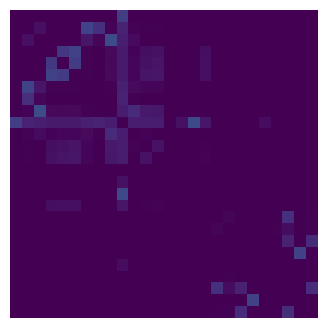

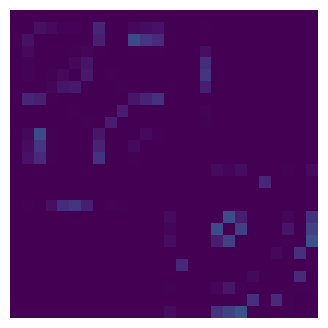

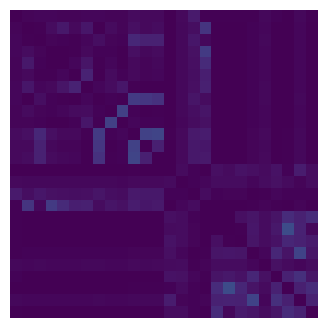

26


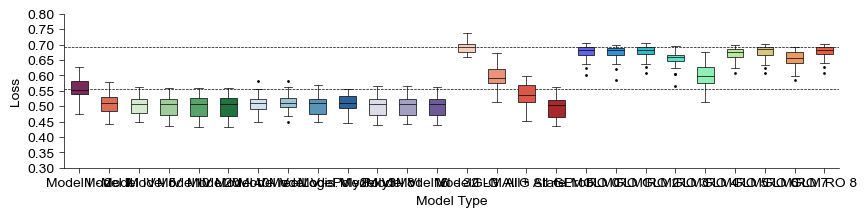

9


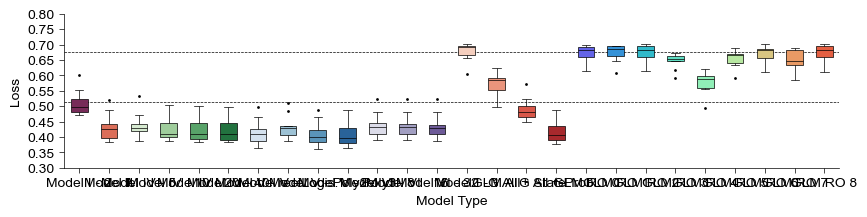

2


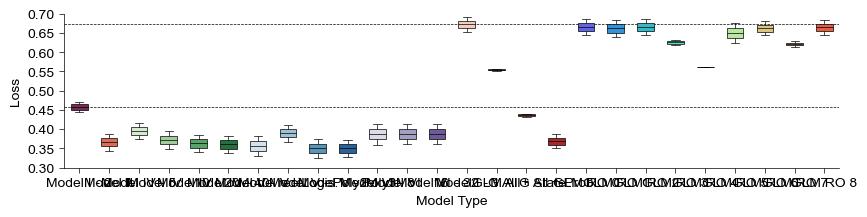

In [6]:
ModelNames = ['Model I - 2', 
                  'Model II', #'Model III',
                  'Model IV - 5', 'Model IV - 10', 'Model IV - 20', 'Model IV - 40',
                  'Model V - reci', 'Model V - Logis.', 'Model V - Poly2', 'Model V - Poly3',
                  'Model VI - 8', 'Model VI - 16', 'Model VI - 32']
    
ModelNames2 = ['Model I - 1', 'GLM All'] + ['G All + State', 'G All + Prob'] + [f'GLM RO {i}' for i in range(9)]

# Statistical test
stat_names = ModelNames + ModelNames2
for i in [6, 12, 18]:
    mat = np.zeros((len(stat_names), len(stat_names)))
    SubData = SubDict(Data, Data.keys(), np.where(Data['Step'] == i)[0])
    for j in range(len(stat_names)-1):
        for k in range(j+1, len(stat_names)):
            mat[j, k] = ttest_rel(SubData['Loss'][SubData['Model Type'] == stat_names[j]], SubData['Loss'][SubData['Model Type'] == stat_names[k]])[1]
            mat[k, j] = mat[j, k]
    
    D = pd.DataFrame(mat, index=stat_names, columns=stat_names)
    D.to_excel(join(figdata, code_id+f'_loss_stat_step{i}.xlsx'), index=False)

    fig = plt.figure(figsize=(4, 4))
    ax = Clear_Axes(plt.axes())
    ax.imshow(mat, vmin=0, vmax=4, aspect='equal')
    plt.show()
idx = np.where(np.isin(Data['Model Type'], ModelNames+ModelNames2))[0]
Data = SubDict(Data, Data.keys(), idx)

idx = np.where(Data['Step'] == 6)[0]
SubData = SubDict(Data, Data.keys(), idx)
a = np.mean(SubData['Loss'][SubData['Model Type'] == 'Model I - 1'])
b = np.mean(SubData['Loss'][SubData['Model Type'] == 'Model I - 2'])
print(np.where(SubData['Model Type'] == 'Model I - 1')[0].shape[0])
fig = plt.figure(figsize=(10, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax.axhline(a, 0, 30, color='k', ls='--', linewidth=0.5)
ax.axhline(b, 0, 30, color='k', ls='--', linewidth=0.5)
sns.boxplot(
    x='Model Type',
    y='Loss',
    hue='Model Type',
    data=SubData,
    order=ModelNames + ModelNames2,
    hue_order=ModelNames + ModelNames2,
    palette=ModelPalette,
    linecolor='black',
    linewidth=0.5,
    gap=0.3,
    flierprops={'markersize': 1},
)
ax.set_ylim(0.3, 0.8)
ax.set_yticks(np.linspace(0.3, 0.8, 11))
plt.savefig(join(loc, "step 7.png"), dpi=600)
plt.savefig(join(loc, "step 7.svg"), dpi=600)
plt.show()

idx = np.where(Data['Step'] == 12)[0]
SubData = SubDict(Data, Data.keys(), idx)
a = np.mean(SubData['Loss'][SubData['Model Type'] == 'Model I - 1'])
b = np.mean(SubData['Loss'][SubData['Model Type'] == 'Model I - 2'])
print(np.where(SubData['Model Type'] == 'Model I - 1')[0].shape[0])
fig = plt.figure(figsize=(10, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax.axhline(a, 0, 30, color='k', ls='--', linewidth=0.5)
ax.axhline(b, 0, 30, color='k', ls='--', linewidth=0.5)
sns.boxplot(
    x='Model Type',
    y='Loss',
    hue='Model Type',
    data=SubData,
    palette=ModelPalette,
    order=ModelNames + ModelNames2,
    hue_order=ModelNames + ModelNames2,
    linecolor='black',
    linewidth=0.5,
    gap=0.3,
    flierprops={'markersize': 1},
)
ax.set_ylim(0.3, 0.8)
ax.set_yticks(np.linspace(0.3, 0.8, 11))
plt.savefig(join(loc, "step 13.png"), dpi=600)
plt.savefig(join(loc, "step 13.svg"), dpi=600)
plt.show()

idx = np.where(Data['Step'] == 18)[0]
SubData = SubDict(Data, Data.keys(), idx)
a = np.mean(SubData['Loss'][SubData['Model Type'] == 'Model I - 1'])
b = np.mean(SubData['Loss'][SubData['Model Type'] == 'Model I - 2'])
print(np.where(SubData['Model Type'] == 'Model I - 1')[0].shape[0])
fig = plt.figure(figsize=(10, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax.axhline(a, 0, 30, color='k', ls='--', linewidth=0.5)
ax.axhline(b, 0, 30, color='k', ls='--', linewidth=0.5)
sns.boxplot(
    x='Model Type',
    y='Loss',
    hue='Model Type',
    data=SubData,
    palette=ModelPalette,
    order=ModelNames + ModelNames2,
    hue_order=ModelNames + ModelNames2,
    linecolor='black',
    linewidth=0.5,
    gap=0.3,
    flierprops={'markersize': 1},
)
ax.set_ylim(0.3, 0.7)
ax.set_yticks(np.linspace(0.3, 0.7, 9))
plt.savefig(join(loc, "step 21.png"), dpi=600)
plt.savefig(join(loc, "step 21.svg"), dpi=600)
plt.show()


        E:\Data\FinalResults\0346 - GLM for all sessions is already existed!


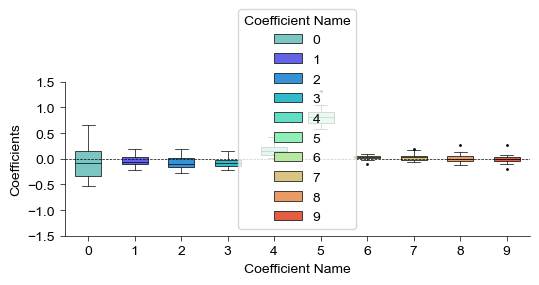

Coef 0, 26: TtestResult(statistic=-0.590978222436145, pvalue=0.5598406926812223, df=25)
Coef 1, 26: TtestResult(statistic=-1.3047412501890312, pvalue=0.20386429954221563, df=25)
Coef 2, 26: TtestResult(statistic=-2.7948550741384803, pvalue=0.009827630594045723, df=25)
Coef 3, 26: TtestResult(statistic=-3.319351947241352, pvalue=0.002769428510531366, df=25)
Coef 4, 26: TtestResult(statistic=7.362852175548791, pvalue=1.0309107639858392e-07, df=25)
Coef 5, 26: TtestResult(statistic=26.232242062833652, pvalue=1.0361725382806367e-19, df=25)
Coef 6, 26: TtestResult(statistic=3.3627246987864217, pvalue=0.0024870336408426325, df=25)
Coef 7, 26: TtestResult(statistic=2.3718975196941607, pvalue=0.025708512795606084, df=25)
Coef 8, 26: TtestResult(statistic=0.8010733838573331, pvalue=0.4306372132193601, df=25)
Coef 9, 26: TtestResult(statistic=-0.09102222889780698, pvalue=0.9282003248431366, df=25)


In [2]:
from mylib.statistic_test import *

code_id = '0346 - GLM for all sessions'
loc = os.path.join(figpath, code_id)
mkdir(loc)

from mylib.model.glms import GLM as GenearlizedLinearModel
from mylib.model import EqualRateDriftModel, TwoProbDriftModel
from mylib.model import TwoProbabilityIndependentModel
from mylib.model import JointProbabilityModel
from mylib.model import HMM
from mylib.model import ContinuousHiddenStateModel
from mylib.model import ProbabilityRNN, IntegrativeRNN

from mylib.field.tracker_v2 import Tracker2d

if exists(join(figdata, code_id+' [coefficients].pkl')):
    with open(join(figdata, code_id+' [coefficients].pkl'), 'rb') as f:
        Coef = pickle.load(f)
else:
    Coef = {
        "MiceID": [],
        "Paradigm": [],
        "Coefficients": [],
        "Coefficient Name": []
    }
    
    for i in range(len(f_CellReg_modi)):
        if f_CellReg_modi['Type'][i] != 'Real' or f_CellReg_modi['maze_type'][i] == 0:
            continue
    
        print(f_CellReg_modi['Trace File'][i])
    
        with open(f_CellReg_modi['Trace File'][i], 'rb') as handle:
            trace = pickle.load(handle)

        param_names = ['Constant'] + [f"{i}" for i in range(9)]
        if f_CellReg_modi['paradigm'][i] == 'CrossMaze':
            mouse = int(f_CellReg_modi['MiceID'][i])
            paradigm = 'MA' if f_CellReg_modi['maze_type'][i] == 1 else 'MB'
            
            ef = []
            for iteration in range(10):
                with open(join(loc, f"{mouse}_{paradigm}_iter{iteration}.pkl"), 'rb') as f:
                    models, models_glm = pickle.load(f)
                    
                params = models_glm[0].results.params
                ef.append(params)
            
            ef = np.vstack(ef)
            Coef['MiceID'].append(np.repeat(mouse, len(params)))
            Coef['Paradigm'].append(np.repeat(paradigm, len(params)))
            Coef['Coefficients'].append(np.mean(ef, axis=0))
            Coef['Coefficient Name'].append(np.arange(10))
        else:
            for dirs in ['cis', 'trs']:
                if f_CellReg_modi['paradigm'][i] == 'ReverseMaze':
                    paradigm = 'MAf' if dirs == 'cis' else 'MAb'
                else:
                    paradigm = 'HPf' if dirs == 'cis' else 'HPb'
                    
                mouse = int(f_CellReg_modi['MiceID'][i])
                
                ef = []
                for iteration in range(10):
                    with open(join(loc, f"{mouse}_{paradigm}_iter{iteration}.pkl"), 'rb') as f:
                        models, models_glm = pickle.load(f)
                    params = models_glm[0].results.params
                    ef.append(params)
                
                ef = np.vstack(ef)
                Coef['MiceID'].append(np.repeat(mouse, len(params)))
                Coef['Paradigm'].append(np.repeat(paradigm, len(params)))
                Coef['Coefficients'].append(np.mean(ef, axis=0))
                Coef['Coefficient Name'].append(np.arange(10))
        
    for k in Coef.keys():
        Coef[k] = np.concatenate(Coef[k])
    
    with open(join(figdata, code_id+' [coefficients].pkl'), 'wb') as f:
        pickle.dump(Coef, f)
        
    D = pd.DataFrame(Coef)
    D.to_excel(join(figdata, code_id+' [coefficients].xlsx'), index=False)
    
fig = plt.figure(figsize=(6, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)

sns.boxplot(
    x = 'Coefficient Name',
    y = 'Coefficients',
    hue = 'Coefficient Name',
    palette=['#6ED3CF']+sns.color_palette("rainbow", 9),
    data=Coef,
    linewidth=0.5,
    linecolor='black',
    gap=0.3,
    flierprops={'markersize': 1, 'color':'black'},
    ax=ax
)
ax.axhline(0, color='k', ls='--', linewidth=0.5)
ax.set_ylim(-1.5, 1.5)
ax.set_yticks(np.linspace(-1.5, 1.5, 7))
plt.savefig(join(loc, "coefficients.png"), dpi=600)
plt.savefig(join(loc, "coefficients.svg"), dpi=600)
plt.show()

for k in np.unique(Coef['Coefficient Name']):
    idx = np.where(Coef['Coefficient Name'] == k)[0]
    print(f"Coef {k}, {len(idx)}: {ttest_1samp(Coef['Coefficients'][idx], 0)}")